In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import fsps
import sedpy
import prospect
from prospect.utils.obsutils import fix_obs
from glob import glob
from astropy.wcs import WCS
from astropy.io import fits
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel

In [2]:
vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))
sedpy_filter_loc='/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/'
print(glob(sedpy_filter_loc+'*'))

numpy: 1.26.3
scipy: 1.11.4
h5py: 3.10.0
fsps: 0.4.6
prospect: 1.2.0
['/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/wise_w2.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/jwst_moda_f115w.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/subaru_suprimecam_ia767.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/subaru_suprimecam_zp.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/wfc3_uvis_f814w.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/uvot_w2.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/hipparcos_B.par', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/filters/herschel_synthphot.pdf', '/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/sedpy/data/f

In [3]:
Photometry=np.genfromtxt('./photometry.csv',delimiter=',',names=True,missing_values=np.nan)
targets={'NGC3705': np.asarray(list(Photometry[3])[1:]),
         'MCG05': np.asarray(list(Photometry[0])[1:]),
         'MCG06': np.asarray(list(Photometry[1])[1:]),
         'UGC9379': np.asarray(list(Photometry[6])[1:]),
         'NVSSJ09': np.asarray(list(Photometry[5])[1:]),
         'NGC6365A': np.asarray(list(Photometry[4])[1:]),
         'NGC3016': np.asarray(list(Photometry[2])[1:])}
filternames=['galex_FUV','galex_NUV','sdss_u0','Johnson_B','Johnson_V',\
    'Cousins_R','sdss_i0','sdss_z0','twomass_J','twomass_H','twomass_Ks','wise_w1','wise_w2',\
        'wise_w3','wise_w4','AKARI_FIS_N60','AKARI_FIS_WIDE-S','AKARI_FIS_WIDE-L','AKARI_FIS_N160']
print(targets['NGC3016'][::2])
print(targets['NGC3016'][1::2])

[16.5   16.03  14.93  13.83  13.17  12.7   12.747 12.569 13.17  13.49
 14.06  13.789 14.336 12.486 11.984    nan  9.05   7.84     nan]
[0.03  0.02  0.01  0.01  0.01  0.01  0.001 0.002 0.03  0.04  0.04  0.022
 0.02  0.017 0.041   nan 0.08  0.78    nan]


In [4]:
testspec=fits.open('./SDSS_Spec/spec_MCG05.fits')[1].data
print(len(fits.open('./SDSS_Spec/spec_MCG05.fits')))

10


[ 47.200314  45.991528  46.545147 ... 100.69298  106.44819  105.70641 ]
[0 0 0 ... 0 0 0]


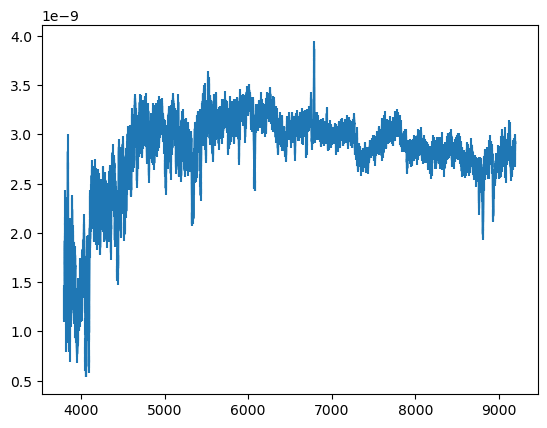

In [5]:
print(testspec['flux'])
#plt.plot(10**testspec['loglam'],(10**(-6))*testspec['flux']/3631)
#plt.errorbar(10**testspec['loglam'],(10**(-6))*testspec['flux']/3631,yerr=(1/np.sqrt((10**(-6))*testspec['ivar']/3631)))
plt.errorbar(10**testspec['loglam'],(10**(-7))*testspec['flux']/3631,yerr=10**(-7)/(np.sqrt(testspec['ivar'])*3631))
#plt.plot(10**testspec['loglam'],(10**(-7))*testspec['sky']/3631)
print(testspec['and_mask'])

In [16]:
target='NGC3705'
spec_scaling={'MCG05':0.2,
'MCG06':0.6,
'NGC3016':0.4,
'NGC3705':None,
'NGC6365A':0.6,
'UGC9379':0.8,
'NVSSJ09':0.3}
redshifts={'MCG05':0.003,
'MCG06':0.02511,
'NGC3016':0.02985,
'NGC3705':0.003,
'NGC6365A':0.02832,
'UGC9379':0.0252,
'NVSSJ09':0.02779}
#Spectra Calibration Adjustments
#NGC3016 0.4
#NGC6365A 0.6
#MCG05 0.2
#MCG06 0.6
#UGC9379 0.8
#NVSSJ09 0.3


obs={}
obs['redshift']=redshifts[target]
obs['filters']=sedpy.observate.load_filters(filternames)
obs['maggies']=np.asarray(list(10**(-0.4*targets[target][::2])))
obs['maggies_unc']=0.921*targets[target][1::2]*obs['maggies']
i=0
while i<len(obs['maggies']):
    if np.isnan(obs['maggies'][i])==True:
        del obs['filters'][i]
        obs['maggies']=np.delete(obs['maggies'],i)
        obs['maggies_unc']=np.delete(obs['maggies_unc'],i)
        i+=1
    i+=1
print(type(obs['maggies']))
obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])
if target!='NGC3705':
    spec=fits.open(f'./SDSS_Spec/spec_{target}.fits')[1].data
    obs['wavelength']=10**spec['loglam']
    obs['spectrum']=(spec_scaling[target])*(10**(-7))*spec['flux']/3631
    obs['unc']=(spec_scaling[target])*10**(-7)/(np.sqrt(spec['ivar'])*3631)
    obs['mask']=spec['and_mask']
    obs['rescale_spectrum']=False
else:
    obs['wavelength']=None
    #obs['spectrum']=None

obs=fix_obs(obs)
print(obs)
print(type(obs))
print(type(obs['maggies']))
#print(mask)
#print(obs['maggies'][mask])



<class 'numpy.ndarray'>
{'redshift': 0.003, 'filters': [<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(Johnson_B), <class 'sedpy.observate.Filter'>(Johnson_V), <class 'sedpy.observate.Filter'>(Cousins_R), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(wise_w4), <class 'sedpy.observate.Filter'>(AKARI_FIS_N60), <class 'sedpy.observate.Filter'>(AKARI_FIS_WIDE-S), <class 'sedpy.observate.Filter'>(AKARI_FIS_WIDE-L), <class 'sedpy.observate.Filter'>(AKARI_FIS_N160)], 'maggies': array([1.23594743e-06, 2.01372425e-06, 7.87045790e-06, 2.67916832e-

Obs Dictionary Keys:

dict_keys(['redshift', 'filters', 'maggies', 'maggies_unc', 'phot_wave', 'wavelength', 'spectrum', 'unc', 'phot_mask', 'filternames', 'logify_spectrum', 'ndof'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(Johnson_B), <class 'sedpy.observate.Filter'>(Johnson_V), <class 'sedpy.observate.Filter'>(Cousins_R), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(wise_w4), <class 'sedpy.observate.Filter'>(AKARI_FIS_N60), <class 'sedpy.observate.Filter'>(AKARI_FIS_WIDE-S), <class 'sedpy.observate.F

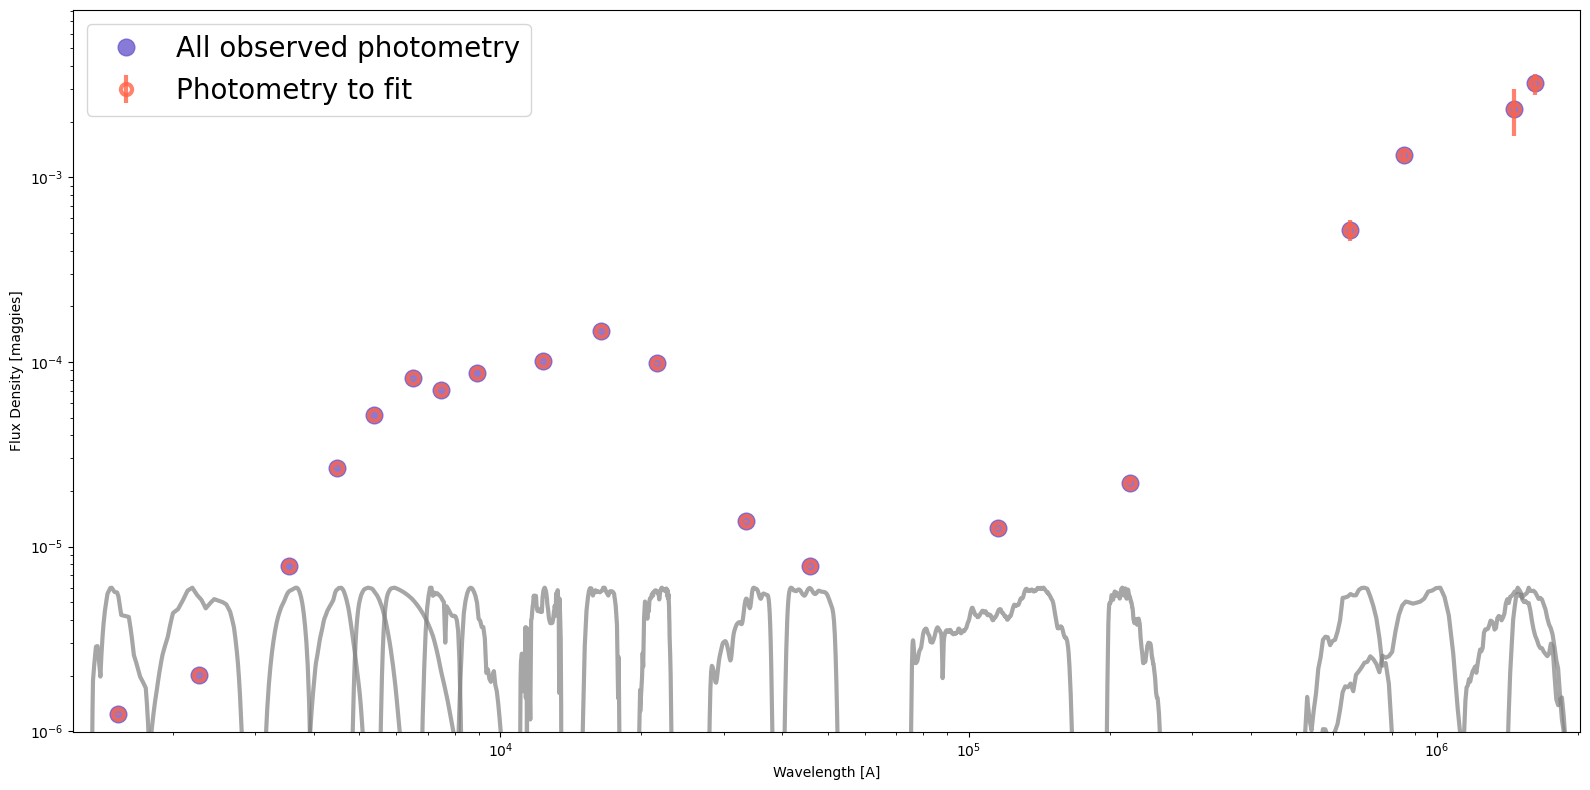

In [17]:
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.nanmin(wphot)*0.8, np.nanmax(wphot)/0.8
ymin, ymax = np.nanmin(obs["maggies"])*0.8, np.nanmax(obs["maggies"])/0.4
plt.figure(figsize=(16,8))

# plot all the data
plt.plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')
if target!='NGC3705':
    plt.plot(obs['wavelength'],obs['wavelength']*obs['spectrum'])

# overplot only the data we intend to fit
mask = obs["phot_mask"]
plt.errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

In [18]:

model_params = TemplateLibrary["parametric_sfh"]
model_params.update(TemplateLibrary["nebular"])
model_params["zred"]["init"] = obs["redshift"]
model = SpecModel(model_params)
assert len(model.free_params) == 5
print(model)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.003] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f792f9d68e0>
  gas_logu: [-2.] 


In [19]:
noise_model = (None, None)

In [20]:
print(model)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.003] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f792f9d68e0>
  gas_logu: [-2.] 


In [21]:
from prospect.sources import CSPSpecBasis
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)

(b'mist', b'miles', b'DL07')


In [22]:
current_parameters = ",".join([f"{p}={v}" for p, v in zip(model.free_params, model.theta)])
print(current_parameters)
spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
print(phot / obs["maggies"])

mass=10000000000.0,logzsol=-0.5,dust2=0.6,tage=1.0,tau=1.0
[ 50.81434119  40.85302615  16.71401241   8.46292318   5.56679374
   3.32390981   3.65214269   3.39237238   3.00960981   2.16475068
   2.62167105  17.70466771  22.76958948 239.23920612 169.04548908
  78.88224621  67.55317877  75.87265083  55.73841115]


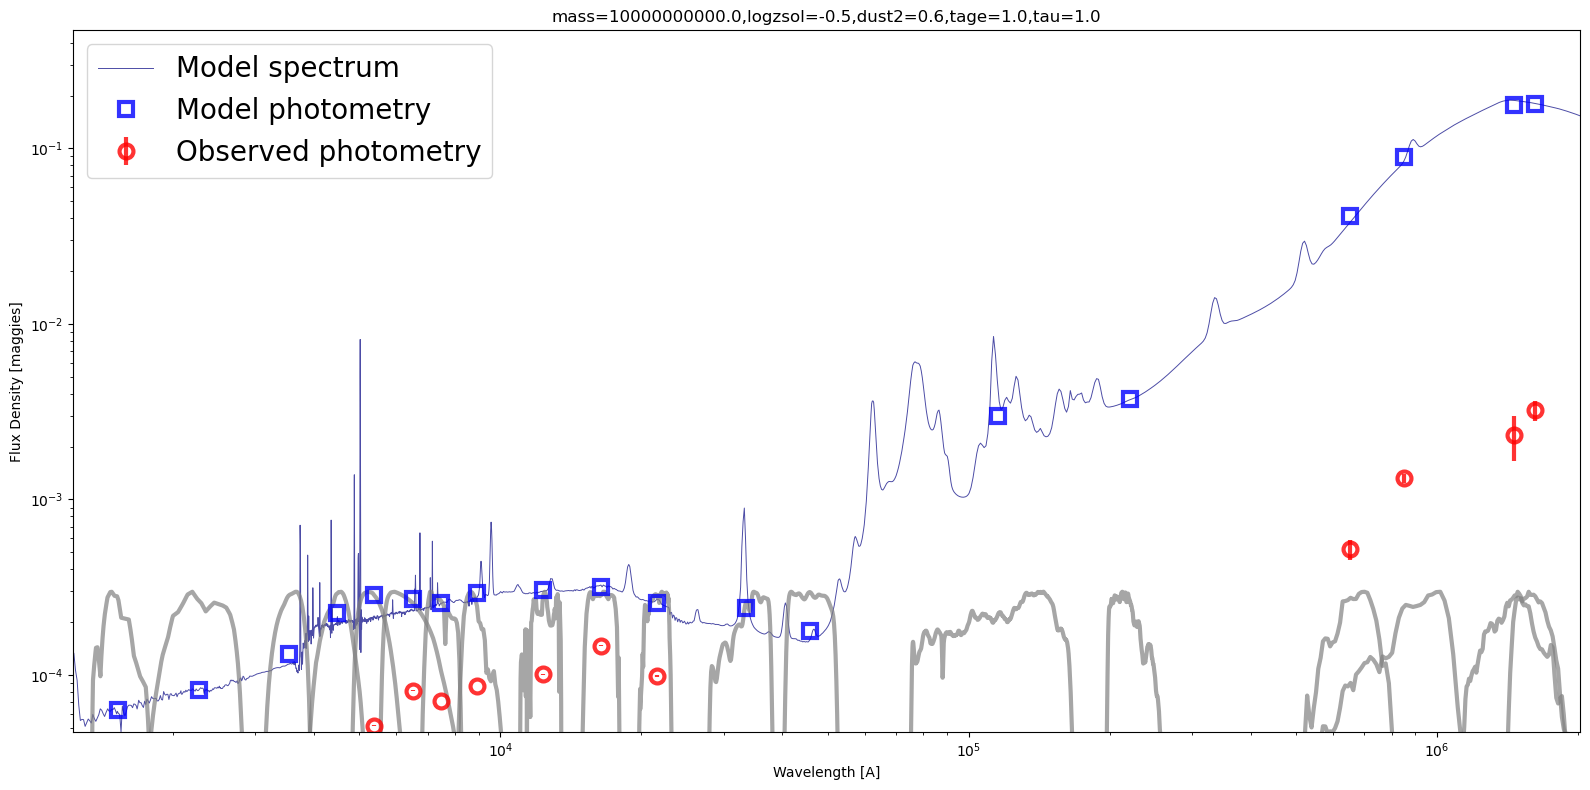

In [23]:
#theta = model.theta.copy()
#spec, phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
plt.figure(figsize=(16,8))

# plot model + data
plt.loglog(wspec, spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
plt.errorbar(wphot, phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
plt.title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

In [24]:
from prospect.fitting import lnprobfn, fit_model
fitting_kwargs = dict(nlive_init=400, nested_method="rwalk", nested_target_n_effective=1000, nested_dlogz_init=0.05)
output = fit_model(obs, model, sps, optimize=True, dynesty=False,emcee=True, lnprobfn=lnprobfn, noise=noise_model, **fitting_kwargs)
result, duration = output["sampling"]

/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/prospect/models/priors.py:117: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


number of walkers=16
done burn #0 (16 iterations)
number of walkers=16
starting production
done production


In [25]:
from prospect.io import write_results as writer
hfile = "./quickstart_emcee_mcmc.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], None,
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=0.0)

/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/home/gjc10/anaconda3/envs/prospect/lib/python3.12/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


In [27]:
from prospect.io import read_results as reader
hfile = "./quickstart_emcee_mcmc.h5"
out, out_obs, out_model = reader.results_from(hfile)

In [30]:
results_type = "emcee"
result, obs, _ = reader.results_from("./quickstart_emcee_mcmc.h5".format(results_type), dangerous=False)

In [34]:
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


[9.86373750e+09 8.59608456e-02 5.15100542e-01 1.21771397e+01
 3.80083012e+00]
Optimization value: [9.86373750e+09 8.59608456e-02 5.15100542e-01 1.21771397e+01
 3.80083012e+00]
MAP value: [9.86373750e+09 8.59608456e-02 5.15100542e-01 1.21771397e+01
 3.80083012e+00]


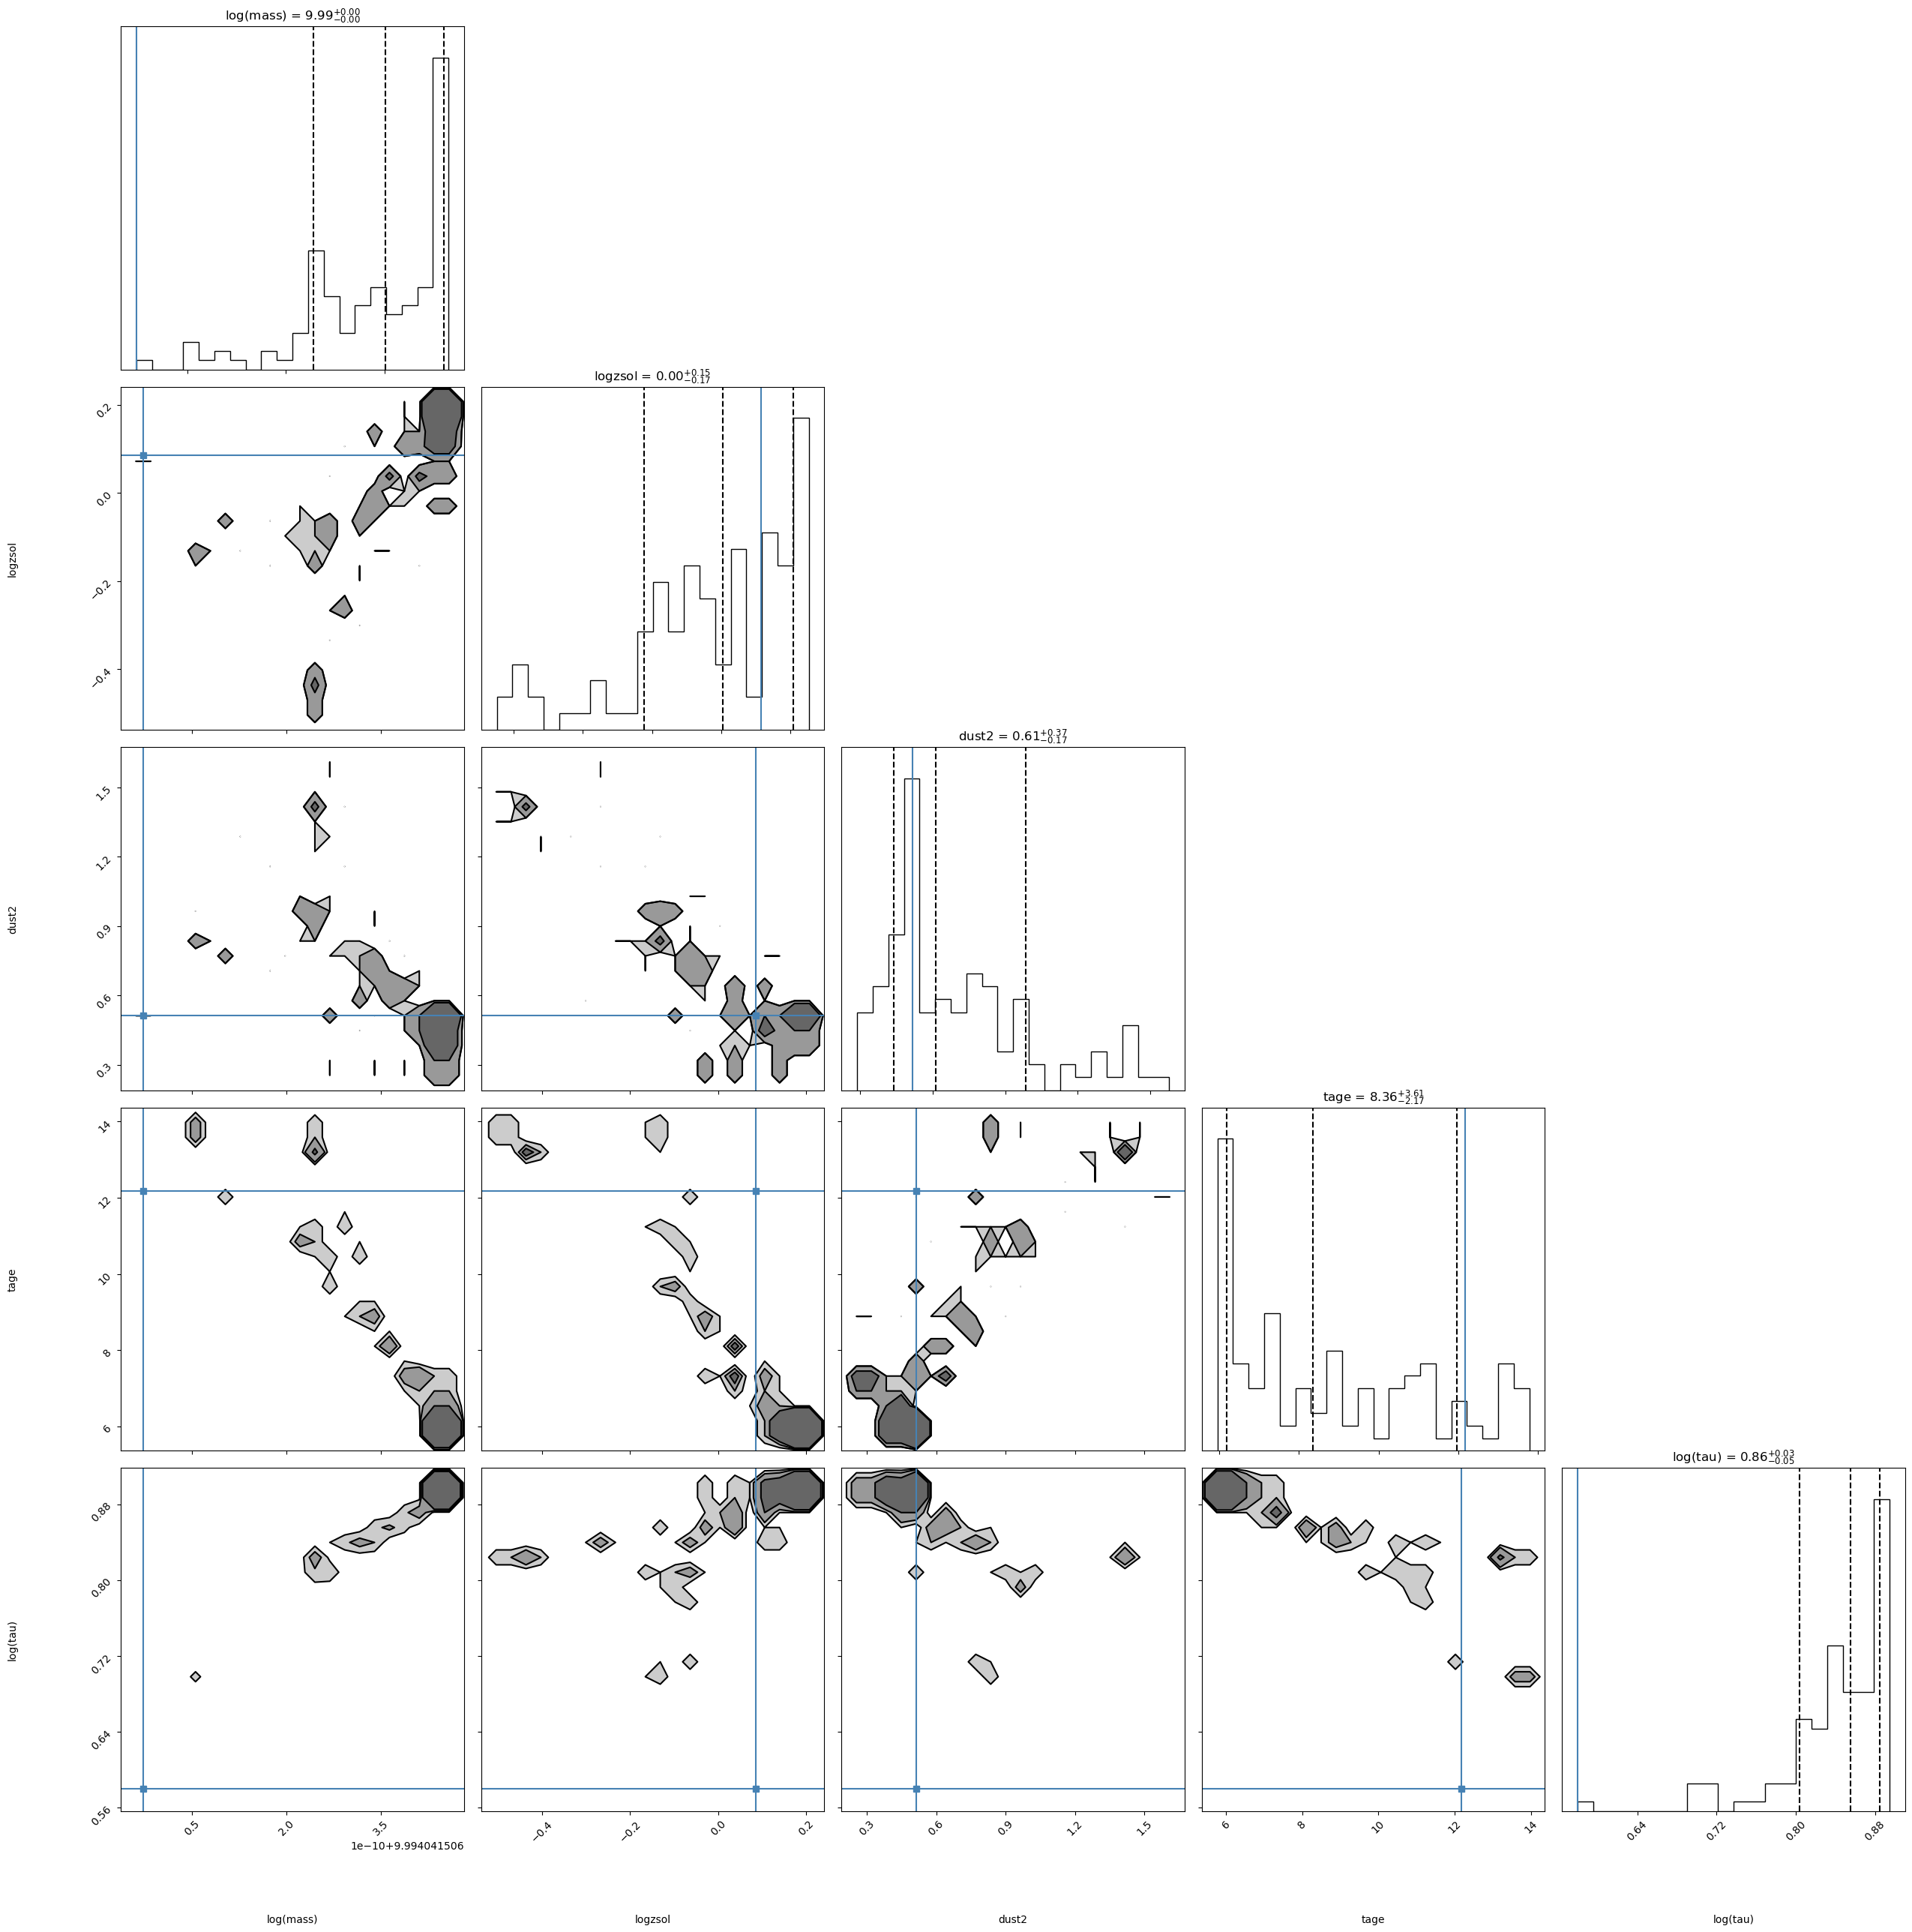

In [38]:
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    print(result['chain'][i, j, :].copy())
    theta_best = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_best = result["chain"][imax, :]
    thin = 1

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best, 
                             fig=plt.subplots(5,5,figsize=(27,27))[0])

In [44]:
imax = np.argmax(result['lnprobability'])
csz = result["chain"].shape
if result["chain"].ndim > 2:
    # emcee
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    flatchain = result["chain"].reshape(csz[0] * csz[1], csz[2])
else:
    # dynesty
    theta_max = result['chain'][imax, :].copy()
    flatchain = result["chain"]

# 16th, 50th, and 84th percentiles of the posterior
from prospect.plotting.corner import quantile
weights = result.get("weights", None)
post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)

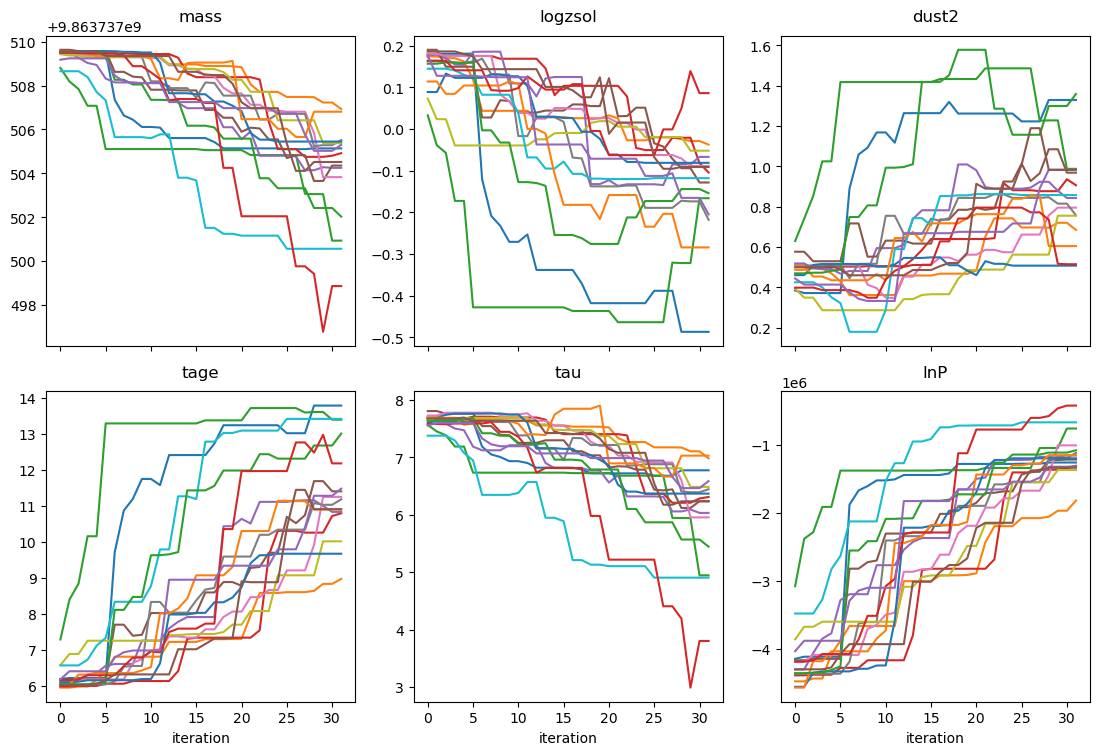

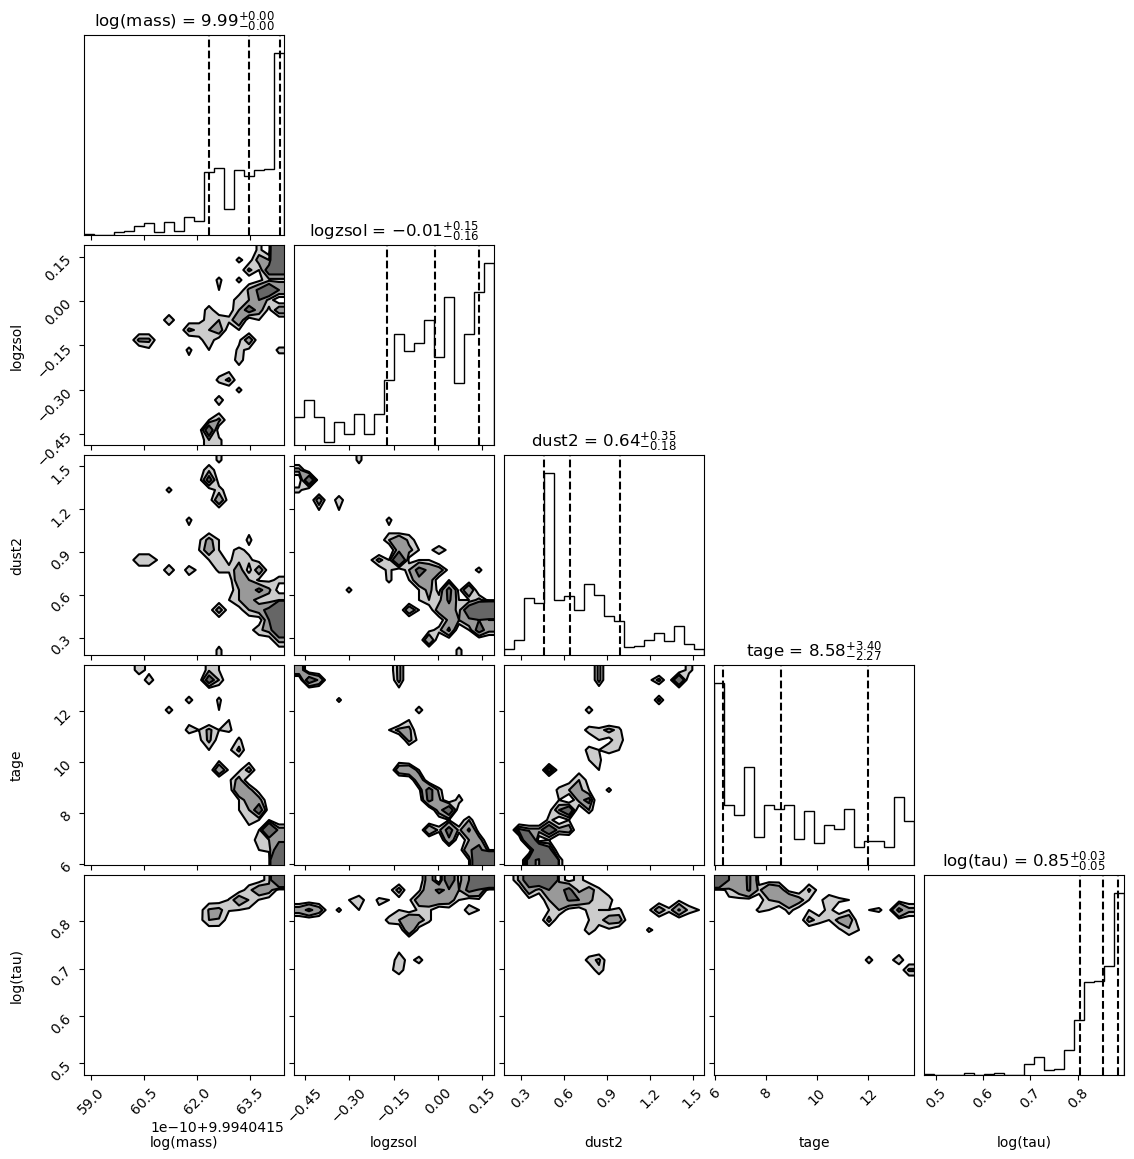

In [45]:
tfig = reader.traceplot(result)
# Corner figure of posterior PDFs
cfig = reader.subcorner(result)

Text(0, 0.5, '$\\chi_{\\rm best}$')

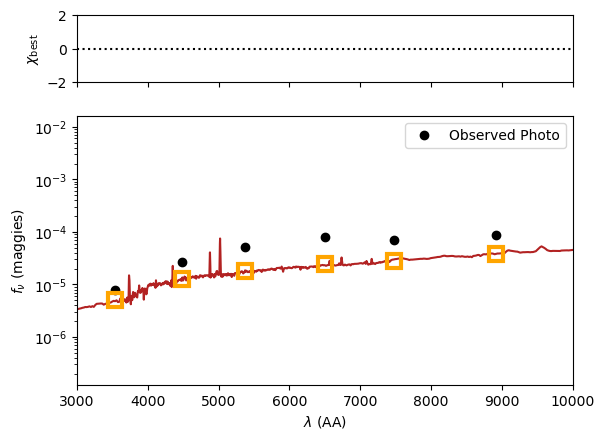

In [47]:
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k",label='Observed Photo')
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(3e3, 1e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")
ax.legend()

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$\chi_{\rm best}$")